In [29]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
import os
import numpy as np
import pandas as pd
from datetime import date
from tqdm import tqdm

import matplotlib.pyplot as plt
import multiprocessing as mp

In [3]:
def update_stocks():
    os.system("rm mstcgl*.zip")
    os.system("rm mstcgl.zip -d data/")
    os.system("wget https://info.bossa.pl/pub/ciagle/mstock/mstcgl.zip")
    os.system("rm -rf data/*")
    os.system("unzip ms*.zip -d data/")
    
    print(f'Updated {date.today()}, max actual date: {prepare_data("WIG20").index.max()}')
    
def prepare_data(papier):
    
    if 'mst' in papier:
        df = pd.read_csv(f'data/{papier}')
    else:    
        df = pd.read_csv(f'data/{papier}.mst')
    df.columns = [str(c).replace('<','') for c in df.columns]
    df.columns = [str(c).replace('>','') for c in df.columns]

    df.loc[:,'DTYYYYMMDD'] = pd.to_datetime(df.loc[:,'DTYYYYMMDD'], format='%Y%m%d')

    df = df.set_index('DTYYYYMMDD')
    
    return df

In [4]:
update_stocks()

Updated 2020-04-02, max actual date: 2020-04-01 00:00:00


In [5]:
all_files = os.listdir('data/')
print(f'no of all available files: {len(all_files)}')

no of all available files: 1937


In [12]:
before_crises = '2020-02-15'
big_drop_date = '2020-03-12'
today = str(date.today())

In [16]:
def plot_paper(papier, plot_range_min, plot_range_max):
    df = prepare_data(papier)

    plot_df = df.loc[(df.index >= plot_range_min) & 
                     (df.index <= plot_range_max),:].copy()
    if not plot_df.shape[0]:
        return 'Nothing to show!'

    spread = (plot_df.loc[:,'CLOSE'].max() - plot_df.loc[:,'CLOSE'].min()) / 14

    plot_df.loc[:,'CLOSE_diff'] = ((plot_df.loc[:,'CLOSE']
                                                - plot_df.loc[:,'CLOSE'].shift(1))
                                                / plot_df.loc[:,'CLOSE'].shift(1)) * 100

    plot_df_bar = ((plot_df.loc[:,'VOL'] - plot_df.loc[:,'VOL'].mean()) 
               / plot_df.loc[:,'VOL'].std() * spread)
    plot_df_bar = plot_df_bar + abs(plot_df_bar.min())
    plot_bar_bottom = plot_df.loc[:,'CLOSE'].min() - plot_df_bar.max()

    plot_df_vol_close = (plot_df.loc[:,'VOL'].rolling(3).mean() * 
             plot_df.loc[:,'CLOSE_diff'].rolling(3).mean())
    plot_df_vol_close = ((plot_df_vol_close - plot_df_vol_close.mean()) / plot_df_vol_close.std() ) * spread
    plot_df_vol_close = plot_df_vol_close + (plot_bar_bottom - plot_df_vol_close.max())
    
    bottom_date = plot_df.loc[plot_df.loc[:,'CLOSE'] == plot_df.loc[:,'CLOSE'].min()].index.strftime('')[0]


    plt.figure(figsize=(20,10))
    plt.plot(plot_df.loc[:,'CLOSE'])
    plt.plot(plot_df_vol_close)

    plt.bar(plot_df_bar.index, 
            plot_df_bar.values,
           bottom = plot_bar_bottom)

    plt.hlines(plot_df.loc[:,'CLOSE'].min(), 
               plot_range_min, plot_range_max, 
               linestyles='--', 
               colors='blue')
#     plt.hlines(plot_df.loc[plot_df.index >= bottom_date,'CLOSE'].max(), 
#                plot_range_min, plot_range_max, 
#                linestyles='--', 
#                colors='red')
    plt.hlines(plot_df.loc[:,'CLOSE'].min()*1.2, 
               plot_range_min, plot_range_max, 
               linestyles='--', 
               colors='red')
    plt.legend([df.TICKER[0],
                'volumen * close',
               'minimum',
               'maksimum',
               'volumen'])
    plt.show()
    
def prepare_stats_forone(papier):
    df = prepare_data(papier)

    df = df.loc[df.index >= '2020-01-01',:]

    before_crises
    data_max_before_crisis = df.loc[(df.index <= before_crises) &
                                 (df.index >= '2020-01-01'),"CLOSE"].max()
    data_max_after_drop = df.loc[df.index >= big_drop_date,"CLOSE"].max()
    data_min_after_max = df.loc[df.index >= df.loc[df.loc[:,'CLOSE'] == data_max_after_drop].index[0], 'CLOSE']
    #data_min_after_max = df.loc[df.index >= (df.loc[df.loc[:,'CLOSE'] == data_max_after_drop].index), 'CLOSE']

    data_crises_min = df.loc[(df.index <= big_drop_date) & 
           (df.index >= before_crises),"CLOSE"].min()
    return data_max_before_crisis, data_crises_min, data_max_after_drop, data_min_after_max

In [ ]:
watch = ['PZU', 
         'KGHM', 
         'ASSECOSEE', 
         'NORTCOAST', 
         'CDPROJEKT', 
         'VOTUM', 
         'NEWAG', 
         'KRUSZWICA', 
         'INTERAOLT', 
         'PLAY', 
         'ARCHICOM', 
         'LPP', 
         'ARCTIC', 
         'PGNIG',
        'TAURONPE', 
         'PKOBP', 
         'JSW']

watch_af = ['KGHM',
            'KRUK', 
            'PKNORLEN',
            'ENEA',
            'MBANK', 
            'PKOBP', 
            'WIELTON']

In [24]:
[a for a in all_files if 'BIOM' in a]

['BIOMEDLUB.mst']

In [25]:
papier = 'BIOMEDLUB'

In [26]:
plot_paper(papier,'2008-07-15','2008-11-15')

'Nothing to show!'

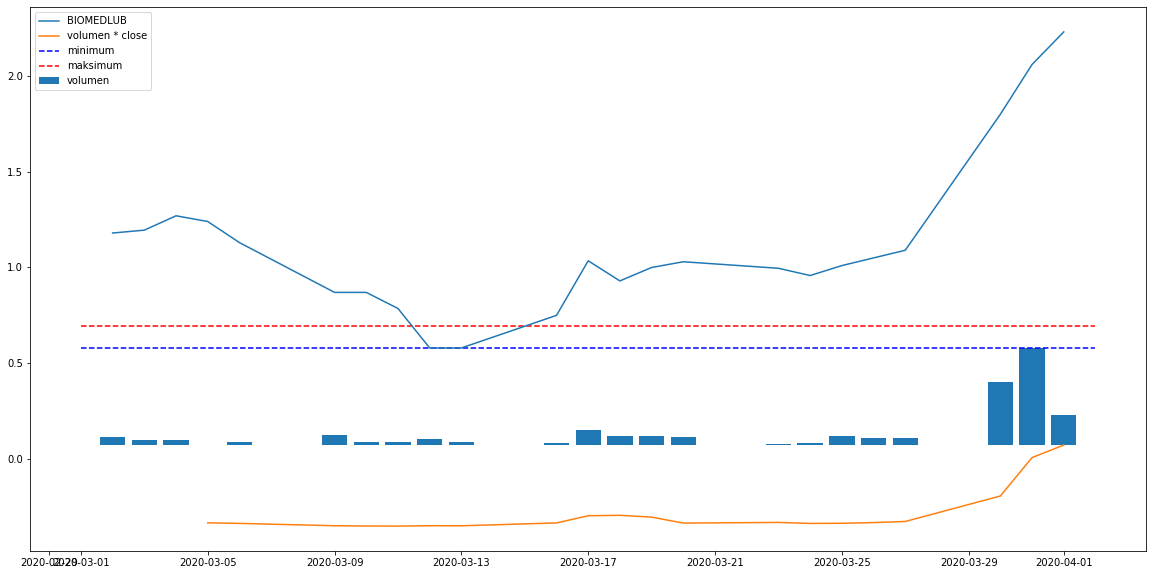

In [30]:
plot_paper(papier,'2020-03-01', str(date.today()))

In [17]:
(data_max_before_crisis, 
 data_crises_min, 
 data_max_after_drop, 
 data_min_after_max) = prepare_stats_forone(papier)

In [18]:
print(f'Max before crisis: {data_max_before_crisis}')
print(f'Crisis bottom: {data_crises_min}')
print(f'Max after crisis drop: {data_max_after_drop}')
print(f'Stats after Max: {data_min_after_max.values}')

Max before crisis: 38.0
Crisis bottom: 25.94
Max after crisis drop: 30.14
Stats after Max: [30.14 29.3  29.28 28.2 ]


## Skaner

In [19]:
before_crisis = '2020-02-17'
top_bottom = '2020-03-12'
new_year = '2020-01-01'
last_y_quarter = '2019-10-01'
last_y_mid = '2019-06-03'

df_cols = ['ticker', 'current', 'before_crisis', 'last_y_q', 'last_y_mid',
           'crisis_bottom', 
           'max_after_crisis', 'max_before_crisis']

### All papers

In [20]:
skaner_df = pd.DataFrame(columns=df_cols)
for w in tqdm(all_files):
    df = pd.read_csv(f'data/{w}')

    df.columns = [str(c).replace('<','') for c in df.columns]
    df.columns = [str(c).replace('>','') for c in df.columns]

    df.loc[:,'DTYYYYMMDD'] = pd.to_datetime(df.loc[:,'DTYYYYMMDD'], format='%Y%m%d')

    df = df.set_index('DTYYYYMMDD')
   
    skaner_df = pd.concat([skaner_df,
                       pd.DataFrame([[
                    df.TICKER[0],
                    df.loc[:,'CLOSE'].tail(1).values[0],
                    df.loc[df.index == before_crisis ,'CLOSE'].max(),
                    df.loc[df.index == last_y_quarter ,'CLOSE'].max(),
                           df.loc[df.index == last_y_mid,'CLOSE'].max(),
                    df.loc[(df.index >= top_bottom) & (df.index <= today),'CLOSE'].min(),
                    df.loc[df.index > top_bottom ,'CLOSE'].max(),
                    df.loc[(df.index >= last_y_quarter) & (df.index <= before_crisis),'CLOSE'].max()
                    
                       ]],
                                    columns=df_cols)], axis = 0)

100%|██████████| 1937/1937 [00:10<00:00, 181.76it/s]


In [21]:
skaner_df.loc[:,'growth_quarter'] = round(skaner_df.loc[:,'before_crisis'] * 100 / skaner_df.loc[:,'last_y_q'] - 100, 2)
skaner_df.loc[:,'growth_mid'] = round(skaner_df.loc[:,'last_y_q'] * 100 / skaner_df.loc[:,'last_y_mid'] - 100, 2)
skaner_df.loc[:,'growth_from_crisis'] = round(skaner_df.loc[:,'max_after_crisis'] * 100 / skaner_df.loc[:,'crisis_bottom'] - 100, 2)
skaner_df.loc[:,'growth_current'] = round(skaner_df.loc[:,'current'] * 100 / skaner_df.loc[:,'crisis_bottom'] - 100, 2)
skaner_df.loc[:,'drop_current'] = round(skaner_df.loc[:,'current'] * 100 / skaner_df.loc[:,'max_before_crisis'] - 100, 2)

In [38]:
skaner_df_see = skaner_df.loc[(skaner_df.growth_quarter > 0) 
        & (skaner_df.growth_mid > 0) 
        & (skaner_df.drop_current < 0) 
        & (skaner_df.growth_current > 10)
                              ,:].sort_values('drop_current', ascending=True)

In [41]:
skaner_df_see

,ticker,current,before_crisis,last_y_q,last_y_mid,crisis_bottom,max_after_crisis,max_before_crisis,growth_quarter,growth_mid,growth_from_crisis,growth_current,drop_current
0,RAINBOW,10.000,35.900,27.000,21.700,5.940,12.300,37.500,32.96,24.42,107.07,68.35,-73.33
0,RCFL4CDPRO,22.040,70.000,25.970,16.850,9.730,25.010,73.000,169.54,54.12,157.04,126.52,-69.81
0,ENTER,16.250,51.400,38.200,32.700,14.000,20.000,52.600,34.55,16.82,42.86,16.07,-69.11
0,RCFL3SILVE,2.170,4.920,4.900,3.200,1.440,2.770,5.480,0.41,53.12,92.36,50.69,-60.40
0,SWISSMED,3.060,5.380,3.200,1.880,2.700,3.560,7.120,68.12,70.21,31.85,13.33,-57.02
0,SUNEX,6.640,13.900,8.800,5.640,5.000,7.500,15.000,57.95,56.03,50.00,32.80,-55.73
0,GRODNO,3.240,7.100,4.140,3.800,2.800,3.480,7.300,71.50,8.95,24.29,15.71,-55.62
0,RCFL3CDPRO1,43.260,96.200,41.880,29.260,24.480,43.260,96.200,129.70,43.13,76.72,76.72,-55.03
0,JWWINVEST,2.000,3.630,1.750,1.070,1.700,2.110,4.200,107.43,63.55,24.12,17.65,-52.38
0,GETIN,0.973,1.574,1.112,1.074,0.750,1.062,1.868,41.55,3.54,41.60,29.73,-47.91


### WIG

In [47]:
skaner_wig_df = pd.DataFrame(columns=df_cols)
for w in tqdm([a for a in all_files if 'WIG' in a]):
    df = pd.read_csv(f'data/{w}')

    df.columns = [str(c).replace('<','') for c in df.columns]
    df.columns = [str(c).replace('>','') for c in df.columns]

    df.loc[:,'DTYYYYMMDD'] = pd.to_datetime(df.loc[:,'DTYYYYMMDD'], format='%Y%m%d')

    df = df.set_index('DTYYYYMMDD')
   
    skaner_wig_df = pd.concat([skaner_wig_df,
                       pd.DataFrame([[
                    df.TICKER[0],
                    df.loc[:,'CLOSE'].tail(1).values[0],
                    df.loc[df.index == before_crisis ,'CLOSE'].max(),
                    df.loc[df.index == last_y_quarter ,'CLOSE'].max(),
                           df.loc[df.index == last_y_mid,'CLOSE'].max(),
                    df.loc[(df.index >= top_bottom) & (df.index <= today),'CLOSE'].min(),
                    df.loc[df.index > top_bottom ,'CLOSE'].max(),
                    df.loc[(df.index >= last_y_quarter) & (df.index <= before_crisis),'CLOSE'].max()
                    
                       ]],
                                    columns=df_cols)], axis = 0)

100%|██████████| 50/50 [00:00<00:00, 144.08it/s]


In [48]:
skaner_wig_df.loc[:,'growth_quarter'] = round(skaner_wig_df.loc[:,'before_crisis'] * 100 / skaner_wig_df.loc[:,'last_y_q'] - 100, 2)
skaner_wig_df.loc[:,'growth_mid'] = round(skaner_wig_df.loc[:,'last_y_q'] * 100 / skaner_wig_df.loc[:,'last_y_mid'] - 100, 2)
skaner_wig_df.loc[:,'growth_from_crisis'] = round(skaner_wig_df.loc[:,'max_after_crisis'] * 100 / skaner_wig_df.loc[:,'crisis_bottom'] - 100, 2)
skaner_wig_df.loc[:,'growth_current'] = round(skaner_wig_df.loc[:,'current'] * 100 / skaner_wig_df.loc[:,'crisis_bottom'] - 100, 2)
skaner_wig_df.loc[:,'drop_current'] = round(skaner_wig_df.loc[:,'current'] * 100 / skaner_wig_df.loc[:,'max_before_crisis'] - 100, 2)
skaner_wig_df_see = skaner_wig_df.loc[(skaner_wig_df.growth_quarter > 0) & 
         (skaner_wig_df.growth_mid > 0) & 
          (skaner_wig_df.drop_current < -15) &
          (skaner_wig_df.growth_current > 10),:].sort_values('drop_current', ascending=True)

In [49]:
skaner_wig_df.sort_values('growth_current')

,ticker,current,before_crisis,last_y_q,last_y_mid,crisis_bottom,max_after_crisis,max_before_crisis,growth_quarter,growth_mid,growth_from_crisis,growth_current,drop_current
0,RCLMWIG40AOPEN,29.15,NaN,NaN,NaN,29.15,29.15,39.31,NaN,NaN,0.00,0.00,-25.85
0,MWIG40DVP,0.57,0.57,110.86,38.96,0.57,0.57,117.22,-99.49,184.55,0.00,0.00,-99.51
0,SWIG80DVP,0.94,NaN,371.67,97.65,0.94,0.94,410.71,NaN,280.61,0.00,0.00,-99.77
0,WIG-NRCHOM,1851.22,2610.21,2288.28,2110.54,1851.22,2132.56,2610.21,14.07,8.42,15.20,0.00,-29.08
0,RCFS2MWIG40,20.29,NaN,NaN,NaN,20.29,20.29,NaN,NaN,NaN,0.00,0.00,NaN
0,RCBMWIG401121,748.10,NaN,NaN,NaN,748.10,748.10,1005.60,NaN,NaN,0.00,0.00,-25.61
0,WIG-BANKI,4047.38,6852.02,7073.65,7513.37,4005.48,4406.52,7327.60,-3.13,-5.85,10.01,1.05,-44.77
0,WIG20SHORT,5024.34,3696.44,3633.11,3490.73,4925.06,5623.80,3826.33,1.74,4.08,14.19,2.02,31.31
0,MWIG40TR,3720.53,5299.43,4779.99,5029.64,3603.52,3869.21,5339.13,10.87,-4.96,7.37,3.25,-30.32
0,MWIG40,2859.06,4072.37,3680.27,3943.69,2769.14,2973.31,4102.88,10.65,-6.68,7.37,3.25,-30.32


## Other

### Reports

In [42]:
all_reports = pd.read_csv('../bizcrap/fundamental_reports.csv')

In [61]:
cols_to_change = list(all_reports.columns)
cols_to_change[0] = 'Data'
all_reports.columns = cols_to_change

In [45]:
[a for a in all_reports.name.unique() if 'ORLEN' in a]

['raporty-PKN-ORLEN,Q.html']

In [55]:
cols_zysk = [c for c in all_reports.columns if 'zysk' in c]

In [53]:
for c in all_reports.columns:
    all_reports.loc[all_reports.loc[:,c]==-1,c] = np.nan

In [62]:
all_reports.head()

,Data,name,przychody_ze_sprzedaży_main,przychody_ze_sprzedaży_kk,przychody_ze_sprzedaży_sector,techniczny_koszt_wytworzenia_produkcji_sprzedanej_main,techniczny_koszt_wytworzenia_produkcji_sprzedanej_kk,techniczny_koszt_wytworzenia_produkcji_sprzedanej_sector,koszty_sprzedaży_main,koszty_sprzedaży_kk,...,odpisy_netto_z_tytułu_utraty_wartości_kredytów_sector,ogólne_koszty_administracyjne_main,ogólne_koszty_administracyjne_kk,ogólne_koszty_administracyjne_sector,wynik_operacyjny_main,wynik_operacyjny_kk,wynik_operacyjny_sector,udział_w_zyskach_jednostek_podporządkowanych_main,udział_w_zyskach_jednostek_podporządkowanych_kk,udział_w_zyskach_jednostek_podporządkowanych_sector
0,2011/Q1,"raporty-ROKITA,Q.html",282089.0,NaN,NaN,236690.0,NaN,NaN,16740.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011/Q2,"raporty-ROKITA,Q.html",120180.0,-57.40,-6.11,104329.0,-55.92,-7.29,7965.0,-52.42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011/Q3,"raporty-ROKITA,Q.html",186398.0,55.10,11.93,163713.0,56.92,4.74,10028.0,25.90,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011/Q4,"raporty-ROKITA,Q.html",232250.0,24.60,24.60,184412.0,12.64,12.64,17560.0,75.11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2012/Q1,"raporty-ROKITA,Q.html",243002.0,4.63,-7.39,202362.0,9.73,-4.46,13294.0,-24.29,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
all_reports.loc[all_reports.name=='raporty-PKN-ORLEN,Q.html',['Data', 'name'] + cols_zysk]

,Data,name,zysk_ze_sprzedaży_main,zysk_ze_sprzedaży_kk,zysk_ze_sprzedaży_sector,zysk_operacyjny_(ebit)_main,zysk_operacyjny_(ebit)_kk,zysk_operacyjny_(ebit)_sector,zysk_z_działalności_gospodarczej_main,zysk_z_działalności_gospodarczej_kk,...,zysk_(strata)_netto_z_działalności_zaniechanej_sector,zysk_netto_main,zysk_netto_kk,zysk_netto_sector,zysk_netto_akcjonariuszy_jednostki_dominującej_main,zysk_netto_akcjonariuszy_jednostki_dominującej_kk,zysk_netto_akcjonariuszy_jednostki_dominującej_sector,udział_w_zyskach_jednostek_podporządkowanych_main,udział_w_zyskach_jednostek_podporządkowanych_kk,udział_w_zyskach_jednostek_podporządkowanych_sector
6856,2005/Q1,"raporty-PKN-ORLEN,Q.html",783503.0,NaN,NaN,797953.0,NaN,NaN,820771.0,NaN,...,NaN,678534.0,NaN,NaN,667527.0,NaN,NaN,NaN,NaN,NaN
6857,2005/Q2,"raporty-PKN-ORLEN,Q.html",1101747.0,40.62,11.69,2615077.0,227.72,9.19,2813959.0,242.84,...,NaN,2565468.0,278.09,38.03,2560212.0,283.54,28.11,NaN,NaN,NaN
6858,2005/Q3,"raporty-PKN-ORLEN,Q.html",1120514.0,1.70,37.29,1090777.0,-58.29,29.90,1221227.0,-56.60,...,NaN,994419.0,-61.24,-0.90,985238.0,-61.52,-0.04,NaN,NaN,NaN
6859,2005/Q4,"raporty-PKN-ORLEN,Q.html",673032.0,-39.94,-24.82,443813.0,-59.31,-34.51,417113.0,-65.84,...,NaN,399355.0,-59.84,-1.46,365479.0,-62.90,-3.24,NaN,NaN,NaN
6860,2006/Q1,"raporty-PKN-ORLEN,Q.html",411141.0,-38.91,33.42,450747.0,1.56,39.40,476236.0,14.17,...,NaN,398153.0,-0.30,49.27,364977.0,-0.14,52.20,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6912,2019/Q1,"raporty-PKN-ORLEN,Q.html",968000.0,86.15,52.80,996000.0,-2.73,31.91,994000.0,2.16,...,NaN,849000.0,37.16,37.16,849000.0,28.25,28.25,NaN,NaN,NaN
6913,2019/Q2,"raporty-PKN-ORLEN,Q.html",1964000.0,102.89,20.46,2086000.0,109.44,52.52,2124000.0,113.68,...,NaN,1601000.0,88.57,62.23,1602000.0,88.69,56.36,NaN,NaN,NaN
6914,2019/Q3,"raporty-PKN-ORLEN,Q.html",1975000.0,0.56,1.69,1807000.0,-13.37,-13.37,1567000.0,-26.22,...,NaN,1266000.0,-20.92,-20.92,1266000.0,-20.97,-23.19,NaN,NaN,NaN
6915,2019/Q4,"raporty-PKN-ORLEN,Q.html",919000.0,-53.47,-16.94,673000.0,-62.76,-32.94,866000.0,-44.74,...,NaN,771000.0,-39.10,-19.55,772000.0,-39.02,-21.16,NaN,NaN,NaN
